# Introduction

Getting startet with Time Series Forecasting can be overwhelming. There are many variations of Time Series problems depending on the number of input or output sequences, the number of steps to predict, whether the input and/or the output sequence length is static or variable, and so on. In this notebook, we will play around with **different types of Time Series Forecasting problems** to become more familiar with them. Since Time Series problems can be a combination of different variations, we will use the example of a lunch menu to showcase the types of variations. 

So, welcome to the "Time Series Bistro". Please have a look the the menu:
* **Main Dish:** Number of input/output sequences
    * Single input and single output with input = output (Univariate with `in` = `out`) 🥗
    * Single input and single output with input $\neq$ output (Multivariate with `in` $\neq$  `out`) 🥯
    * Multiple inputs and multiple outputs with inputs = outputs (Multivariate with `in[N]` = `out[N]`) 🥪
    * Multiple inputs and multiple outputs with inputs $\neq$ outputs (Multivariate with `in[N]` $\neq$  `out[N]`) 🌯 
* **Drink Menu:** Length of output sequences
    * Single step output sequence 🥤
    * Multistep output sequence 
        * Predict all steps at once (Single-shot) ☕️
        * Predict single step at a time and feedback to model to predict for multiple steps (recursive) 🍵
* **Dessert:** Type of input sequence
    * Static length input sequence (Sliding Window) 🍎
    * Variable length input sequence (Expanding Window) 🍌
    * Additionally, you can specify the window's step size

For example, you could have one sequence for which you are trying to predict its values for the next 5 timesteps based on the previous 10 timesteps, which would be a univariate multistep time series problem with a sliding window (🥗🍎☕️). Or you could try to predict the amount of snow for the next day based on all available past data of temperature and rain. This would be a multivariate single step time series problem with an expanding window (🌯🍌🥤).

**Disclaimer: The following is a work in progress. I will add, edit and correct sections as I learn about the different time series problems myself. If you find errors or if anything is unclear, please feel free to share it. It's appreciated.**

In [2]:
import numpy as np # linear algebra
from numpy.random import seed 

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, date 

#from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

from IPython.display import display_html # To visualize dataframes side by side
import os
N_EPOCHS = 32
SEED = 42

# Fix seed for reproducible results
os.environ['PYTHONHASHSEED']=str(SEED)
seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Data Overview
The following is a fictional time series that we will use to test the baseline on. There are three features. `feature_1` is following a sine wave, `feature_2` is a linear function, and `feature_3` is a modulo function. The `feature_4` column is the result of a combination of the feature columns. The time series consists of 100 timesteps.

,timestamp,feature_1,feature_2,feature_3,feature_4
0,2021-01-01,22.479328,25.0,70.0,107.437985
1,2021-01-02,24.694438,25.5,71.0,114.318035
2,2021-01-03,26.395715,26.0,72.0,119.826717
3,2021-01-04,27.508409,26.5,73.0,123.651489
4,2021-01-05,27.983630,27.0,74.0,125.547617


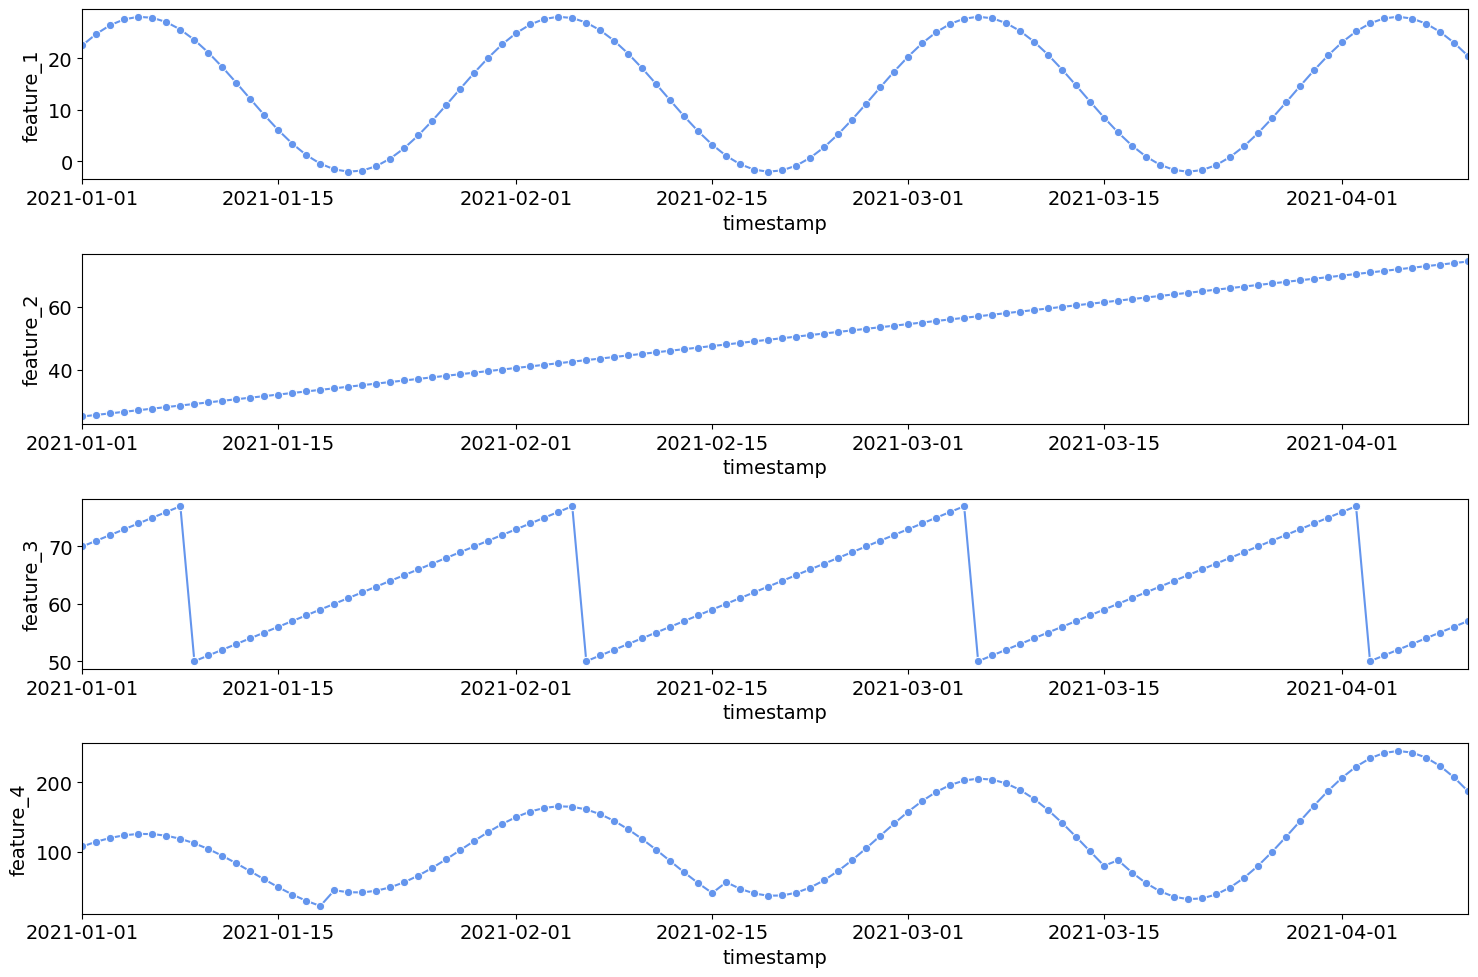

In [3]:
### Build fictional time series for experimenting ###
time        = np.arange(0, 1100, 10)

ts_df = pd.DataFrame({'feature_1' : 15*np.sin(0.021*time+30)+13,
                      'feature_2' : (0.05*time)+20,
                      'feature_3' : (( time + 100 ) % 280)*0.1 + 50,
                     })

# Create feature_4
ts_df['feature_4'] =  0.1 * ts_df.feature_1 * (ts_df.feature_2 + 5) - ts_df.feature_3.shift(10) + 100

# Drop first 90 rows due to shifted variables
ts_df = ts_df[10:110]

# Create timestamps and set as index
ts_df['timestamp'] = pd.date_range('2021-01-01', periods=100, freq='D')
ts_df.set_index('timestamp', inplace=True)
ts_df.reset_index(drop=False, inplace=True)

display(ts_df.head())

### Visualize time series ###
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))
sns.lineplot(x=ts_df.timestamp, y=ts_df.feature_1, ax=ax[0], color='cornflowerblue', marker='o')
sns.lineplot(x=ts_df.timestamp, y=ts_df.feature_2, ax=ax[1], color='cornflowerblue', marker='o')
sns.lineplot(x=ts_df.timestamp, y=ts_df.feature_3, ax=ax[2], color='cornflowerblue', marker='o')
sns.lineplot(x=ts_df.timestamp, y=ts_df.feature_4, ax=ax[3], color='cornflowerblue', marker='o')

for i in range(4):
    ax[i].set_xlim([date(2021, 1, 1), date(2021, 4, 10)])
plt.tight_layout()
plt.show()

The following function will help us build our lunch menu. It will take your input and/or output sequences and return you the training and testing data according to your order. You can specify the length of the input sequence, the length of the output sequence, and the step size of your window.

In [4]:
def split_sequences(features, targets, n_steps_in, n_steps_out, n_sliding_steps, window_type):
    """
    Edited from 
    https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    
    Args:
    * features: univariate or multivariate input sequences
    * targets: univariate or multivariate output sequences
    * n_steps_in: length of input sequence for sliding window. 
    * n_steps_out: length of output sequence
    * n_sliding_steps: window step size
    * window_type: 'sliding' or 'expanding'
    """
    X, y = list(), list()
    for i in range(0, len(features), n_sliding_steps):

        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequences
        if out_end_ix > len(features):
            break
            
        # gather input and output parts of the pattern
        if window_type == 'sliding': # Sliding window
            seq_x, seq_y = features[i:end_ix, :], targets[end_ix:out_end_ix, :]
        else: # expanding window
            seq_x, seq_y = features[0:end_ix, :], targets[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
### Plotting functions ###
def plot_time_series_problem(X, y):
    fig, ax = plt.subplots(nrows=X.shape[0], ncols=1, figsize=(15, 2.5*X.shape[0]))
    for i in range(X.shape[0]):
        sns.lineplot(x=ts_df['timestamp'].values, y=ts_df['feature_1'].values, ax=ax[i], color='lightgrey', marker='o')

        if i < X.shape[0]-1:
            sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 1].astype(float), ax=ax[i], color='cornflowerblue', label='train', marker='o')
            sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 1].astype(float), ax=ax[i], color='orange', label='val', marker='o')
            ax[i].set_title(f"Training Sample {i}")
        else:
            sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 1].astype(float), ax=ax[i], color='mediumseagreen', label='in', marker='o')
            sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 1].astype(float), ax=ax[i], color='coral', label='pred', marker='o')
            ax[i].set_title(f"Testing")    
        ax[i].set_xlim([date(2021, 1, 1), date(2021, 4, 11)])

    plt.tight_layout()
    plt.show()  

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'cornflowerblue', label='Training loss')
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'orange', label='Validation loss')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim([-0.1, 20])
    plt.legend()

    plt.show()

# Fundamentals
Before we jump into the modelling, let's have a look at the menu items.

## Number of Input/Output Sequences
First, we will look at the number of input/output sequences (main dishes). To make things easier to understand, we will only variate the number of input/output sequences (main dish), an we will keep the length of the output sequences (drinks) and the type of input sequences (dessert) same for the following. We will use a multistep output sequence (☕️) of 5 steps and the sliding window (🍎) setting with a stepsize of 20  for this. 

In [6]:
### Help functions ###
def display_input_and_output_df(input_cols, output_cols):
    ts_df_styler1 = ts_df[input_cols].head().style.set_table_attributes("style='display:inline'").set_caption('Input (X)')
    ts_df_styler2 = ts_df[output_cols].head().style.set_table_attributes("style='display:inline'").set_caption('Output (y)')

    display_html(ts_df_styler1._repr_html_()+ts_df_styler2._repr_html_(), raw=True)

### Univariate: Single input and single output with input = output 🥗

In [7]:
input_cols = ['timestamp', 'feature_1']
output_cols = input_cols

In [8]:
display_input_and_output_df(input_cols, output_cols)

X, y = split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = 15, 
                       n_steps_out = 5, 
                       n_sliding_steps = 20, 
                       window_type='sliding')

fig, ax = plt.subplots(nrows=X.shape[0], ncols=1, figsize=(15, 2.5*X.shape[0]))
fig.suptitle('Univariate: Single input and single output with input = output')
for i in range(X.shape[0]):
    sns.lineplot(x=ts_df['timestamp'].values, y=ts_df['feature_1'].values, ax=ax[i], color='lightgrey', marker='o')

    if i < X.shape[0]-1:
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 1].astype(float), ax=ax[i], color='cornflowerblue', label='input', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 1].astype(float), ax=ax[i], color='orange', label='output', marker='o')
        ax[i].set_title(f"Training Sample {i}")
    else:
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 1].astype(float), ax=ax[i], color='mediumseagreen', label='input', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 1].astype(float), ax=ax[i], color='coral', label='predict', marker='o')
        ax[i].set_title(f"Testing")    
    ax[i].set_xlim([date(2021, 1, 1), date(2021, 4, 11)])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() 

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

### Multivariate: Multiple inputs and multiple outputs with inputs = outputs 🥪

In [ ]:
input_cols = ['timestamp', 'feature_1', 'feature_2']
output_cols = input_cols

In [ ]:
display_input_and_output_df(input_cols, output_cols)

X, y = split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = 15, 
                       n_steps_out = 5, 
                       n_sliding_steps = 20, 
                       window_type='sliding')

fig, ax = plt.subplots(nrows=X.shape[0], ncols=2, figsize=(15, 2.5*X.shape[0]))
fig.suptitle(r'Multivariate: Multiple inputs and multiple outputs with input = output')

for i in range(X.shape[0]):
    sns.lineplot(x=ts_df['timestamp'].values, y=ts_df['feature_1'].values, ax=ax[i, 0], color='lightgrey', marker='o')
    sns.lineplot(x=ts_df['timestamp'].values, y=ts_df['feature_2'].values, ax=ax[i, 1], color='lightgrey', marker='o')

    if i < X.shape[0]-1:
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 1].astype(float), ax=ax[i, 0], color='cornflowerblue', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 1].astype(float), ax=ax[i, 0], color='orange', marker='o')
        
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 2].astype(float), ax=ax[i, 1], color='cornflowerblue', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 2].astype(float), ax=ax[i, 1], color='orange', marker='o')
        
        ax[i, 0].set_title(f"Training Sample {i}")
        ax[i, 1].set_title(f"Training Sample {i}")

    else:
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 1].astype(float), ax=ax[i, 0], color='mediumseagreen', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 1].astype(float), ax=ax[i, 0], color='coral', marker='o')
        
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 2].astype(float), ax=ax[i, 1], color='mediumseagreen', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 2].astype(float), ax=ax[i, 1], color='coral', marker='o')
        ax[i, 0].set_title(f"Testing Sample")    
        ax[i, 1].set_title(f"Testing Sample (Prediction)")    

    ax[i, 0].set_xlim([date(2021, 1, 1), date(2021, 4, 11)])
    ax[i, 1].set_xlim([date(2021, 1, 1), date(2021, 4, 11)])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() 

### Multivariate: Single input and single output with input $\neq$ output 🥗

In [ ]:
input_cols = ['timestamp', 'feature_1']
output_cols = ['timestamp', 'feature_4']

In [ ]:
display_input_and_output_df(input_cols, output_cols)

X, y = split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = 15, 
                       n_steps_out = 5, 
                       n_sliding_steps = 20, 
                       window_type='sliding')

fig, ax = plt.subplots(nrows=X.shape[0], ncols=2, figsize=(15, 2.5*X.shape[0]))
fig.suptitle(r'Multivariate: Single input and single output with input $\neq$ output')

for i in range(X.shape[0]):
    sns.lineplot(x=ts_df['timestamp'].values, y=ts_df['feature_1'].values, ax=ax[i, 0], color='lightgrey', marker='o')
    sns.lineplot(x=ts_df['timestamp'].values, y=ts_df['feature_4'].values, ax=ax[i, 1], color='lightgrey', marker='o')

    if i < X.shape[0]-1:
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 1].astype(float), ax=ax[i, 0], color='cornflowerblue', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 1].astype(float), ax=ax[i, 1], color='orange', marker='o')
        ax[i, 0].set_title(f"Input Sequence of Training Sample {i}")
        ax[i, 1].set_title(f"Output Sequence of Training Sample {i}")

    else:
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 1].astype(float), ax=ax[i, 0], color='mediumseagreen', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 1].astype(float), ax=ax[i, 1], color='coral', marker='o')
        ax[i, 0].set_title(f"Input Sequence of Testing Sample")    
        ax[i, 1].set_title(f"Output Sequence of Testing Sample (Prediction)")    

    ax[i, 0].set_xlim([date(2021, 1, 1), date(2021, 4, 11)])
    ax[i, 1].set_xlim([date(2021, 1, 1), date(2021, 4, 11)])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() 

### Multivariate: Multiple inputs and multiple outputs with inputs ≠ outputs 🌯 

In [ ]:
input_cols = ['timestamp', 'feature_1', 'feature_2']
output_cols = ['timestamp', 'feature_3', 'feature_4']

In [ ]:
display_input_and_output_df(input_cols, output_cols)

X, y = split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = 15, 
                       n_steps_out = 5, 
                       n_sliding_steps = 20, 
                       window_type='sliding')

fig, ax = plt.subplots(nrows=X.shape[0]*2, ncols=2, figsize=(15, 2.5*X.shape[0]*2))
fig.suptitle(r'Multivariate: Single input and single output with input $\neq$ output')

for i in range(X.shape[0]):
    sns.lineplot(x=ts_df['timestamp'].values, y=ts_df['feature_1'].values, ax=ax[(i*2), 0], color='lightgrey', marker='o')
    sns.lineplot(x=ts_df['timestamp'].values, y=ts_df['feature_2'].values, ax=ax[(i*2)+1, 0], color='lightgrey', marker='o')

    sns.lineplot(x=ts_df['timestamp'].values, y=ts_df['feature_3'].values, ax=ax[(i*2), 1], color='lightgrey', marker='o')
    sns.lineplot(x=ts_df['timestamp'].values, y=ts_df['feature_4'].values, ax=ax[(i*2)+1, 1], color='lightgrey', marker='o')

    if i < X.shape[0]-1:
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 1].astype(float), ax=ax[(i*2), 0], color='cornflowerblue', marker='o')
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 2].astype(float), ax=ax[(i*2)+1, 0], color='cornflowerblue', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 1].astype(float), ax=ax[(i*2), 1], color='orange', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 2].astype(float), ax=ax[(i*2)+1, 1], color='orange', marker='o')
        ax[(i*2), 0].set_title(f"Input Sequence 1 of Training Sample {i}")
        ax[(i*2), 1].set_title(f"Output Sequence 1 of Training Sample {i}")

        ax[(i*2)+1, 0].set_title(f"Input Sequence 2 of Training Sample {i}")
        ax[(i*2)+1, 1].set_title(f"Output Sequence 2 of Training Sample {i}")

    else:
        #sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 1].astype(float), ax=ax[(i*2), 0], color='mediumseagreen', marker='o')
        #sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 1].astype(float), ax=ax[(i*2)+1, 1], color='coral', marker='o')
        
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 1].astype(float), ax=ax[(i*2), 0], color='mediumseagreen', marker='o')
        sns.lineplot(x=X[i][ :, 0], y=X[i][ :, 2].astype(float), ax=ax[(i*2)+1, 0], color='mediumseagreen', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 1].astype(float), ax=ax[(i*2), 1], color='coral', marker='o')
        sns.lineplot(x=y[i][ :, 0], y=y[i][ :, 2].astype(float), ax=ax[(i*2)+1, 1], color='coral', marker='o')
        
        ax[(i*2), 0].set_title(f"Input Sequence 1 of Testing Sample {i}")
        ax[(i*2), 1].set_title(f"Output Sequence 1 of Testing Sample {i} (Prediction)")

        ax[(i*2)+1, 0].set_title(f"Input Sequence 2 of Testing Sample {i}")
        ax[(i*2)+1, 1].set_title(f"Output Sequence 2 of Testing Sample {i} (Prediction)")

    ax[i, 0].set_xlim([date(2021, 1, 1), date(2021, 4, 11)])
    ax[i, 1].set_xlim([date(2021, 1, 1), date(2021, 4, 11)])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() 

## Length of Output Sequences
Next, we will look at the length of output sequences (drinks). For this example, we will will keep the number of input/output sequences (main dishes) and the type of input sequences (dessert) same for the following. We will use a univariate (🥗) problem with the sliding window (🍎) setting with a stepsize of 20  for this. 

### Single Step Output Sequence 🥤

In [ ]:
input_cols = ['timestamp', 'feature_1']
output_cols = input_cols

X, y = split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = 19, 
                       n_steps_out = 1, 
                       n_sliding_steps = 20, 
                       window_type='sliding')

plot_time_series_problem(X, y)

### Multistep Output Sequence ☕️

In [ ]:
X, y = split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = 15, 
                       n_steps_out = 5, 
                       n_sliding_steps = 20, 
                       window_type='sliding')

plot_time_series_problem(X, y)

## Type of Input Sequences
Finally, we will look at the type of input sequences (desserts). For this example, we will will keep the number of input/output sequences (main dishes) and length of the output sequences (drinks) same for the following. We will use a univariate (🥗) problem with a multistep output sequence (☕️) of 5 steps for this. 

### Sliding Window 🍎


In [ ]:
X, y = split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = 15, 
                       n_steps_out = 5, 
                       n_sliding_steps = 20, 
                       window_type='sliding')

plot_time_series_problem(X, y)

### Expanding Window

In [ ]:
X, y = split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = 15, 
                       n_steps_out = 5, 
                       n_sliding_steps = 20, 
                       window_type='expanding')

plot_time_series_problem(X, y)

# Baseline

Alright! Now that we understand the theory, let's get some practice in solving these problems. 

First, we will get familiar with our baseline by experimenting with the simples problem setting. The first menu option is the **Univariate Single Step Problem with Sliding Window** (🥗🥤🍎). For this problem setting, we will use `feature_1` as input and also as output sequence. Based on the sliding window method, we will create samples of constant length. Each sample is going to be 20 steps long: 19 steps from the input sequence (`n_steps_in`) and 1 step to predict (`n_steps_out`). If we use a window size of 20 (`n_sliding_steps`), we will not reuse any data points and we get a total of 5 samples (100 timesteps / 20 sliding steps). We will use 4 samples for training and one sample for testing. (Unide output to see the visualized samples --> )

As the baseline for the following experiments we will use a **simple LSTM module followed by a Dense layer**. Depending on the Time Series problem, the following three parameter have to be adjusted:
* Length of input sequence: `input_seq_length` = 19
* Length of output sequence: `output_seq_length` = 1
* Number of sequences: `n_features` = 1

In [ ]:
input_seq_length = 19
output_seq_length = 1
n_features = 1

# Define model
model = Sequential()
model.add(LSTM(100, 
               activation='relu', 
               input_shape=(input_seq_length, n_features)))
model.add(Dense(output_seq_length))
model.compile(optimizer='adam', loss='mse')

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
input_cols = ['timestamp', 'feature_1']
output_cols = input_cols

X_all, y_all =split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = input_seq_length, 
                       n_steps_out = output_seq_length, 
                       n_sliding_steps = 20, 
                       window_type='sliding')

n_samples = X_all.shape[0]
print(f"Total of {n_samples} samples created.")

plot_time_series_problem(X_all, y_all)

# Data for training/validation
X = X_all[:(n_samples - 1)]
y = y_all[:(n_samples - 1)]

# Data for testing
X_test = X_all[(n_samples - 1):]
y_test = y_all[(n_samples - 1):]

In [ ]:
# Split training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Covert to float and reshape
index_X_train = X_train[:, :, 0]
index_y_train = y_train[:, :, 0]
index_X_val = X_val[:, :, 0]
index_y_val = y_val[:, :, 0]
index_X_test = X_test[:, :, 0]
index_y_test = y_test[:, :, 0]

X_train = X_train[:, :, 1].astype(float).reshape((X_train.shape[0], 
                                                  input_seq_length, 
                                                  n_features))
X_val = X_val[:, :, 1].astype(float).reshape((X_val.shape[0], 
                                              input_seq_length, 
                                              n_features))
X_test = X_test[:, :, 1].astype(float).reshape((X_test.shape[0], 
                                                input_seq_length, 
                                                n_features))

y_train = y_train[:, :, 1].astype(float)
y_val = y_val[:, :, 1].astype(float)
y_test = y_test[:, :, 1].astype(float)

# Fit model
history = model.fit(X_train, y_train, # Training data
                    validation_data=(X_val, y_val), # Validation data
                    epochs = N_EPOCHS, # Number of epochs
                    verbose = 0, # Don't show output. Set to 1 to see output
                    shuffle=False
                    )

# Visalize loss over epochs
plot_history(history)
    
# Predict
y_pred = model.predict(X_test, verbose=0)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

#sns.lineplot(x=index_X_test[0], y=X_test[0].reshape(-1), ax=ax, color='mediumseagreen', label='in', marker='o')
sns.lineplot(x=ts_df[output_cols].values[:, 0], y=ts_df[output_cols].values[:, 1].astype(float), ax=ax, color='grey', label='in', marker='o')
sns.lineplot(x=index_y_test[0], y=y_test[0].reshape(-1), ax=ax, color='coral', label='out', marker='o')
sns.lineplot(x=index_y_test[0], y=y_pred[0].reshape(-1), ax=ax, color='red', label='pred', marker='X', markersize=8)

ax.set_title(f"Testing (MSE: {mean_squared_error(y_pred, y_test):.6f})")    
#ax.set_xlim([date(2021, 3, 21), date(2021, 4, 11)])

plt.tight_layout()
plt.show() 

# Window Stepsize
The issue with the above example is that we only got 5 samples from the sequence with a window stepsize of 20. If we use one sample for testing and need at least 1 sample for cross validation, that leaves us with very little training data. An alternative would be to **use a smaller window stepsize**. If we use a stepsize of 1, we can generate 81 samples from the same timeseries instead of only 5.

(Unide output to see the visualized samples --> )

In [ ]:
input_seq_length = 19
output_seq_length = 1

input_cols = ['timestamp', 'feature_1']
output_cols = input_cols

X_all, y_all =split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = input_seq_length, 
                       n_steps_out = output_seq_length, 
                       n_sliding_steps = 1, 
                       window_type='sliding')

n_samples = X_all.shape[0]
print(f"Total of {n_samples} samples created.")

plot_time_series_problem(X_all, y_all)

In [ ]:
# Data for training/validation
X = X_all[:(n_samples - 1)]
y = y_all[:(n_samples - 1)]

# Data for testing
X_test = X_all[(n_samples - 1):]
y_test = y_all[(n_samples - 1):]

n_features = X_all.shape[2] - 1 # column timestep is not a feature

# Define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(input_seq_length, n_features)))
model.add(Dense(output_seq_length))
model.compile(optimizer='adam', loss='mse')

# Split training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Covert to float and reshape
index_X_train = X_train[:, :, 0]
index_y_train = y_train[:, :, 0]
index_X_val = X_val[:, :, 0]
index_y_val = y_val[:, :, 0]
index_X_test = X_test[:, :, 0]
index_y_test = y_test[:, :, 0]

X_train = X_train[:, :, 1].astype(float).reshape((X_train.shape[0], input_seq_length, n_features))
y_train = y_train[:, :, 1].astype(float)

X_val = X_val[:, :, 1].astype(float).reshape((X_val.shape[0], input_seq_length, n_features))
y_val = y_val[:, :, 1].astype(float)

X_test = X_test[:, :, 1].astype(float).reshape((X_test.shape[0], input_seq_length, n_features))
y_test = y_test[:, :, 1].astype(float)

# Fit model
history = model.fit(X_train, y_train, # Training data
                    validation_data=(X_val, y_val), # Validation data
                    epochs = N_EPOCHS, # Number of epochs
                    verbose = 0, # Don't show output. Set to 1 to see output
                    shuffle=False
                    )

# Visalize loss over epochs
plot_history(history)
    
# Predict
y_pred = model.predict(X_test, verbose=0)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

#sns.lineplot(x=index_X_test[0], y=X_test[0].reshape(-1), ax=ax, color='mediumseagreen', label='in', marker='o')
sns.lineplot(x=ts_df[output_cols].values[:, 0], y=ts_df[output_cols].values[:, 1].astype(float), ax=ax, color='grey', label='in', marker='o')
sns.lineplot(x=index_y_test[0], y=y_test[0].reshape(-1), ax=ax, color='coral', label='out', marker='o')
sns.lineplot(x=index_y_test[0], y=y_pred[0].reshape(-1), ax=ax, color='red', label='pred', marker='X', markersize=8)

ax.set_title(f"Testing (MSE: {mean_squared_error(y_pred, y_test):.6f})")    
#ax.set_xlim([date(2021, 3, 21), date(2021, 4, 11)])

plt.tight_layout()
plt.show() 

We can see that **increasing the number of samples by decreasing the step size has improved the MSE metric**. Therefore, we can say that if there is no specification against it, we should try to use the smallest stepsize possible to increase the models performance.

# Data Leakage

The next item on the menu is the **Univariate Multi Step Problem with Sliding Window** (🥗☕️🍎).
We will increase the number of timesteps to predict from one (🥤) to many (☕️). In this example, we will keep the sample length of 20 but instead of 19 input and 1 output timesteps, we will now have 15 input and 5 output timesteps. We will keep the window stepsize as 1 from the previous example.

(Unide output to see the visualized samples --> )

In [ ]:
input_seq_length = 15
output_seq_length = 5

input_cols = ['timestamp', 'feature_1']
output_cols = input_cols

X_all, y_all = split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = input_seq_length, 
                       n_steps_out = output_seq_length, 
                       n_sliding_steps = 1, 
                       window_type='sliding')

n_samples = X_all.shape[0]
print(f"Total of {n_samples} samples created.")

plot_time_series_problem(X_all, y_all)


When working with time series, we **need to be careful with data leakage**. That means, we cannot train the model on future data and use it to make predictions about the past. By splitting the time series into chronologically ordered samples, we are already taking one measure to avoid the risk of data leakage. However, now that we want to predict 5 time steps into the future, we have the following issue: 

Below you can see the last two training samples and the test sample. We want to predict the very last 5 timesteps of this time series. However, you can see that the last training sample ("training sample 1") already used 4 out 5 future timesteps for validation. Similarly, the second to last sample ("training sample 0") uses 3 out of 5 future timesteps for validation. That means, we are about to have data leakage because we would be using 4 samples in the training data (as validation data) and in the testing data. 

In [ ]:
plot_time_series_problem(X_all[-3:], y_all[-3:])

To avoid the **data leakage here, we should make sure that the timesteps for prediction are not present in the training data**. The input sequence for the testing data can be available in both since this is a forecasting problem setting. To do so, we have to throw out the last 4 samples from the training data by using `:(n_samples - output_seq_length)` instead of `:(n_samples - 1)` for the indices of the training data.

In [ ]:
# Data for training/validation
X = X_all[:(n_samples - output_seq_length)]
y = y_all[:(n_samples - output_seq_length)]

# Data for testing
X_test = X_all[(n_samples - 1):]
y_test = y_all[(n_samples - 1):]

In [ ]:
n_features = X_all.shape[2] - 1 # column timestep is not a feature

# Define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(input_seq_length, n_features)))
model.add(Dense(output_seq_length))
model.compile(optimizer='adam', loss='mse')

# Split training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Covert to float and reshape
index_X_train = X_train[:, :, 0]
index_y_train = y_train[:, :, 0]
index_X_val = X_val[:, :, 0]
index_y_val = y_val[:, :, 0]
index_X_test = X_test[:, :, 0]
index_y_test = y_test[:, :, 0]

X_train = X_train[:, :, 1].astype(float).reshape((X_train.shape[0], input_seq_length, n_features))
y_train = y_train[:, :, 1].astype(float)

X_val = X_val[:, :, 1].astype(float).reshape((X_val.shape[0], input_seq_length, n_features))
y_val = y_val[:, :, 1].astype(float)

X_test = X_test[:, :, 1].astype(float).reshape((X_test.shape[0], input_seq_length, n_features))
y_test = y_test[:, :, 1].astype(float)

# Fit model
history = model.fit(X_train, y_train, # Training data
                    validation_data=(X_val, y_val), # Validation data
                    epochs = N_EPOCHS, # Number of epochs
                    verbose = 0, # Don't show output. Set to 1 to see output
                    shuffle=False
                    )

# Visalize loss over epochs
plot_history(history)
    
# Predict
y_pred = model.predict(X_test, verbose=0)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=ts_df[output_cols].values[:, 0], y=ts_df[output_cols].values[:, 1].astype(float), ax=ax, color='grey', label='in', marker='o')
#sns.lineplot(x=index_X_test[0], y=X_test[0].reshape(-1), ax=ax, color='mediumseagreen', label='in', marker='o')
sns.lineplot(x=index_y_test[0], y=y_test[0].reshape(-1), ax=ax, color='coral', label='out', marker='o')
sns.lineplot(x=index_y_test[0], y=y_pred[0].reshape(-1), ax=ax, color='red', label='pred', marker='X', markersize=8)

ax.set_title(f"Testing (MSE: {mean_squared_error(y_pred, y_test):.6f})")    
#ax.set_xlim([date(2021, 3, 21), date(2021, 4, 11)])

plt.tight_layout()
plt.show() 

# Length of Forecast
In menu 1, we predicted a single timestep into the future (🥤) and in menu 2, we predicted multiple but a fixed number of timesteps in the future (☕️). But what if you would like to **predict a variable length of timesteps** into the future? 

Let's have a look at the next menu item: **Univariate Autoregressive Multi Step Problem with Sliding Window** (🥗🍵🍎). In this case, we predict a single timestep for multiple timesteps by feeding the predicted timestep back to the as a timestep in the input sequence. 

First, we will reuse the model from the first menu - the univariate single step problem with sliding window (🥗🥤🍎).


In [ ]:
# the univariate single step problem with sliding window (🥗🥤🍎)
input_seq_length = 19
output_seq_length = 1

input_cols = ['timestamp', 'feature_1']
output_cols = input_cols

X_all, y_all =split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = input_seq_length, 
                       n_steps_out = output_seq_length, 
                       n_sliding_steps = 1, 
                       window_type='sliding')

n_samples = X_all.shape[0]

# Data for training/validation
X = X_all[:(n_samples - 1)]
y = y_all[:(n_samples - 1)]

# Data for testing
X_test = X_all[(n_samples - 1):]
y_test = y_all[(n_samples - 1):]

n_features = X_all.shape[2] - 1 # column timestep is not a feature

# Define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(input_seq_length, n_features)))
model.add(Dense(output_seq_length))
model.compile(optimizer='adam', loss='mse')

# Split training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Covert to float and reshape
index_X_train = X_train[:, :, 0]
index_y_train = y_train[:, :, 0]
index_X_val = X_val[:, :, 0]
index_y_val = y_val[:, :, 0]
index_X_test = X_test[:, :, 0]
index_y_test = y_test[:, :, 0]

X_train = X_train[:, :, 1].astype(float).reshape((X_train.shape[0], input_seq_length, n_features))
y_train = y_train[:, :, 1].astype(float)

X_val = X_val[:, :, 1].astype(float).reshape((X_val.shape[0], input_seq_length, n_features))
y_val = y_val[:, :, 1].astype(float)

X_test = X_test[:, :, 1].astype(float).reshape((X_test.shape[0], input_seq_length, n_features))
y_test = y_test[:, :, 1].astype(float)

# Fit model
history = model.fit(X_train, y_train, # Training data
                    validation_data=(X_val, y_val), # Validation data
                    epochs = N_EPOCHS, # Number of epochs
                    verbose = 0, # Don't show output. Set to 1 to see output
                    shuffle=False
                    )

In [ ]:
n_timesteps_to_predict = 10

X_test_mod = X_test.copy()
y_preds = []
for n in range(n_timesteps_to_predict):
    y_pred = model.predict(X_test_mod, verbose=0)
    X_test_mod = np.append(X_test_mod, [y_pred], axis=1)
    X_test_mod = X_test_mod[:,1:, :]
    y_preds = np.append(y_preds, y_pred)

As you might have expected, this methods works quite well for a few timesteps. However, the greater the number of timesteps to predict becomes, the larger the error that gets carried over becomes. Therefore, **the further in the future you are trying to predict, the less reliable your prediction can become**.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=ts_df[output_cols].values[:, 0], y=ts_df[output_cols].values[:, 1].astype(float), ax=ax, color='grey', label='in', marker='o')
sns.lineplot(x=index_y_test[0], y=y_test[0].reshape(-1), ax=ax, color='coral', label='out', marker='o')
sns.lineplot(x=pd.date_range(index_X_test[0][-1], periods=n_timesteps_to_predict+1, freq='D')[1:], y=y_preds, ax=ax, color='red', label='pred', marker='X', markersize=8)
ax.set_title(f"Predict {n_timesteps_to_predict} Timesteps")    

plt.tight_layout()
plt.show() 

n_timesteps_to_predict = 100

X_test_mod = X_test.copy()
y_preds = []
for n in range(n_timesteps_to_predict):
    y_pred = model.predict(X_test_mod, verbose=0)
    X_test_mod = np.append(X_test_mod, [y_pred], axis=1)
    X_test_mod = X_test_mod[:,1:, :]
    y_preds = np.append(y_preds, y_pred)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=ts_df[output_cols].values[:, 0], y=ts_df[output_cols].values[:, 1].astype(float), ax=ax, color='grey', label='in', marker='o')
sns.lineplot(x=index_y_test[0], y=y_test[0].reshape(-1), ax=ax, color='coral', label='out', marker='o')
sns.lineplot(x=pd.date_range(index_X_test[0][-1], periods=n_timesteps_to_predict+1, freq='D')[1:], y=y_preds, ax=ax, color='red', label='pred', marker='X', markersize=8)
ax.set_title(f"Predict {n_timesteps_to_predict} Timesteps")    

plt.tight_layout()
plt.show() 

n_timesteps_to_predict = 200

X_test_mod = X_test.copy()
y_preds = []
for n in range(n_timesteps_to_predict):
    y_pred = model.predict(X_test_mod, verbose=0)
    X_test_mod = np.append(X_test_mod, [y_pred], axis=1)
    X_test_mod = X_test_mod[:,1:, :]
    y_preds = np.append(y_preds, y_pred)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=ts_df[output_cols].values[:, 0], y=ts_df[output_cols].values[:, 1].astype(float), ax=ax, color='grey', label='in', marker='o')
sns.lineplot(x=index_y_test[0], y=y_test[0].reshape(-1), ax=ax, color='coral', label='out', marker='o')
sns.lineplot(x=pd.date_range(index_X_test[0][-1], periods=n_timesteps_to_predict+1, freq='D')[1:], y=y_preds, ax=ax, color='red', label='pred', marker='X', markersize=8)
ax.set_title(f"Predict {n_timesteps_to_predict} Timesteps")    

plt.tight_layout()
plt.show() 



We saw that the baseline worked quite well for the sine wave feature (`feature_1`). Let's try it out and see if the baseline can handle different signal types as well. We will use `input_seq_length` = 15, `output_seq_length` = 15, and 256 epochs.

In [ ]:
def plot_experiment_1(input_cols):
    input_seq_length = 15
    output_seq_length = 15

    #input_cols = ['timestamp', 'feature_3']
    output_cols = input_cols

    X_all, y_all = split_sequences(ts_df[input_cols].values, 
                           ts_df[output_cols].values, 
                           n_steps_in = input_seq_length, 
                           n_steps_out = output_seq_length, 
                           n_sliding_steps = 1, 
                           window_type='sliding')

    n_samples = X_all.shape[0]
    #print(f"Total of {n_samples} samples created.")

    #plot_time_series_problem(X_all, y_all)

    # Data for training/validation
    X = X_all[:(n_samples - output_seq_length)]
    y = y_all[:(n_samples - output_seq_length)]

    # Data for testing
    X_test = X_all[(n_samples - 1):]
    y_test = y_all[(n_samples - 1):]


    n_features = X_all.shape[2] - 1 # column timestep is not a feature

    # Define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(input_seq_length, n_features)))
    model.add(Dense(output_seq_length))
    model.compile(optimizer='adam', loss='mse')

    # Split training and validation data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Covert to float and reshape
    index_X_train = X_train[:, :, 0]
    index_y_train = y_train[:, :, 0]
    index_X_val = X_val[:, :, 0]
    index_y_val = y_val[:, :, 0]
    index_X_test = X_test[:, :, 0]
    index_y_test = y_test[:, :, 0]

    X_train = X_train[:, :, 1].astype(float).reshape((X_train.shape[0], input_seq_length, n_features))
    y_train = y_train[:, :, 1].astype(float)

    X_val = X_val[:, :, 1].astype(float).reshape((X_val.shape[0], input_seq_length, n_features))
    y_val = y_val[:, :, 1].astype(float)

    X_test = X_test[:, :, 1].astype(float).reshape((X_test.shape[0], input_seq_length, n_features))
    y_test = y_test[:, :, 1].astype(float)

    # Fit model
    history = model.fit(X_train, y_train, # Training data
                        validation_data=(X_val, y_val), # Validation data
                        epochs = N_EPOCHS*8, # Number of epochs
                        verbose = 0, # Don't show output. Set to 1 to see output
                        shuffle=False
                        )

    # Visalize loss over epochs
    #plot_history(history)

    # Predict
    y_pred = model.predict(X_test, verbose=0)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

    sns.lineplot(x=ts_df[output_cols].values[:, 0], y=ts_df[output_cols].values[:, 1].astype(float), ax=ax, color='grey', label='in', marker='o')
    #sns.lineplot(x=index_X_test[0], y=X_test[0].reshape(-1), ax=ax, color='mediumseagreen', label='in', marker='o')
    sns.lineplot(x=index_y_test[0], y=y_test[0].reshape(-1), ax=ax, color='coral', label='out', marker='o')
    sns.lineplot(x=index_y_test[0], y=y_pred[0].reshape(-1), ax=ax, color='red', label='pred', marker='X', markersize=8)

    ax.set_title(f"Testing (MSE: {mean_squared_error(y_pred, y_test):.6f})")    
    #ax.set_xlim([date(2021, 3, 21), date(2021, 4, 11)])

    plt.tight_layout()
    plt.show() 
    
plot_experiment_1(['timestamp', 'feature_1'])
plot_experiment_1(['timestamp', 'feature_2'])
plot_experiment_1(['timestamp', 'feature_3'])
plot_experiment_1(['timestamp', 'feature_4'])

We can see that this is working quite well for `feature_1`. However, the simple linear function `feature_2` cannot be fitted perfectly. Also, the modulo function `feature_3` only roughly immitates the ground truth and the most complex constructed signal `feature_4` is completely off.

# Feature Engineering
Another way to approach this problem is to try some feature engineering. 

In [ ]:
ts_df['dayofyear'] = pd.DatetimeIndex(ts_df['timestamp']).dayofyear
ts_df['month'] = pd.DatetimeIndex(ts_df['timestamp']).month

week = 7
month = 30

ts_df['week_sin'] = np.sin(ts_df['dayofyear'] * (2 * np.pi / week))
ts_df['week_cos'] = np.cos(ts_df['dayofyear'] * (2 * np.pi / week))
ts_df['month_sin'] = np.sin(ts_df['dayofyear'] * (2 * np.pi / month))
ts_df['month_cos'] = np.cos(ts_df['dayofyear'] * (2 * np.pi / month))

ts_df.head()

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(10, 12))
sns.lineplot(x=ts_df.timestamp, y=ts_df.dayofyear, ax=ax[0], color='cornflowerblue', marker='o')
sns.lineplot(x=ts_df.timestamp, y=ts_df.week_sin, ax=ax[1], color='cornflowerblue', marker='o')
sns.lineplot(x=ts_df.timestamp, y=ts_df.week_cos, ax=ax[2], color='cornflowerblue', marker='o')
sns.lineplot(x=ts_df.timestamp, y=ts_df.month, ax=ax[3], color='cornflowerblue', marker='o')
sns.lineplot(x=ts_df.timestamp, y=ts_df.month_sin, ax=ax[4], color='cornflowerblue', marker='o')
sns.lineplot(x=ts_df.timestamp, y=ts_df.month_cos, ax=ax[5], color='cornflowerblue', marker='o')

for i in range(4):
    ax[i].set_xlim([date(2021, 1, 1), date(2021, 4, 10)])
plt.tight_layout()
plt.show()

In [ ]:
fft = tf.signal.rfft(ts_df['feature_1'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(ts_df['feature_1'])
days_per_month = 366
years_per_dataset = n_samples_h/(days_per_month)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
#plt.xscale('log')
plt.ylim(0,1000)
plt.xlim([0, 20])
#plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
#_ = plt.xlabel('Frequency (log scale)')


In [ ]:
input_seq_length = 15
output_seq_length = 15

input_cols = ['timestamp', 'feature_1']#, 'dayofyear']# 'week_sin', 'week_cos', 'month_sin', 'month_cos' ]
output_cols = ['timestamp', 'feature_1', ]

X_all, y_all = split_sequences(ts_df[input_cols].values, 
                       ts_df[output_cols].values, 
                       n_steps_in = input_seq_length, 
                       n_steps_out = output_seq_length, 
                       n_sliding_steps = 1, 
                       window_type='sliding')

n_samples = X_all.shape[0]
#print(f"Total of {n_samples} samples created.")

#plot_time_series_problem(X_all, y_all)

# Data for training/validation
X = X_all[:(n_samples - output_seq_length)]
y = y_all[:(n_samples - output_seq_length)]

# Data for testing
X_test = X_all[(n_samples - 1):]
y_test = y_all[(n_samples - 1):]


n_features = X_all.shape[2] - 1 # column timestep is not a feature

# Define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(input_seq_length, n_features)))#, return_sequences=True, ))
#model.add(LSTM(100, activation='relu'))
model.add(Dense(output_seq_length))
model.compile(optimizer='adam', loss='mse')

# Split training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Covert to float and reshape
index_X_train = X_train[:, :, 0]
index_y_train = y_train[:, :, 0]
index_X_val = X_val[:, :, 0]
index_y_val = y_val[:, :, 0]
index_X_test = X_test[:, :, 0]
index_y_test = y_test[:, :, 0]

X_train = X_train[:, :, 1:].astype(float).reshape((X_train.shape[0], input_seq_length, n_features))
y_train = y_train[:, :, 1:].astype(float)

X_val = X_val[:, :, 1:].astype(float).reshape((X_val.shape[0], input_seq_length, n_features))
y_val = y_val[:, :, 1:].astype(float)

X_test = X_test[:, :, 1:].astype(float).reshape((X_test.shape[0], input_seq_length, n_features))
y_test = y_test[:, :, 1:].astype(float)

# Fit model
history = model.fit(X_train, y_train, # Training data
                    validation_data=(X_val, y_val), # Validation data
                    epochs = N_EPOCHS, # Number of epochs
                    verbose = 0, # Don't show output. Set to 1 to see output
                    shuffle=False
                    )

# Visalize loss over epochs
#plot_history(history)

# Predict
y_pred = model.predict(X_test, verbose=0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(x=ts_df[output_cols].values[:, 0], y=ts_df[output_cols].values[:, 1].astype(float), ax=ax, color='grey', label='in', marker='o')
#sns.lineplot(x=index_X_test[0], y=X_test[0].reshape(-1), ax=ax, color='mediumseagreen', label='in', marker='o')
sns.lineplot(x=index_y_test[0], y=y_test[0].reshape(-1), ax=ax, color='coral', label='out', marker='o')
sns.lineplot(x=index_y_test[0], y=y_pred[0].reshape(-1), ax=ax, color='red', label='pred', marker='X', markersize=8)

ax.set_title(f"Testing (MSE: {mean_squared_error(y_pred[0], y_test.reshape(-1)):.6f})")    
#ax.set_xlim([date(2021, 3, 21), date(2021, 4, 11)])

plt.tight_layout()
plt.show() 

# TL;DR
* Using a smaller stepsize increases the number of available samples for training and therefore can increase the models performance
* Data leakage can happen easily in time series problems. Always double check if you are not using samples in training and testing
* The further in the future we try to predict, the less reliable our predictions are.

# References
## My Time Series Forecasting Series

* [Intro to Time Series Forecasting](https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting)
* [Time Series Forecasting: Building Intuition](https://www.kaggle.com/iamleonie/time-series-forecasting-building-intuition)
* [Time Series Forecasting: Interpreting ACF and PACF](https://www.kaggle.com/iamleonie/time-series-interpreting-acf-and-pacf)
* [Time Series Forecasting: Tips & Tricks for Training LSTMs](https://www.kaggle.com/iamleonie/time-series-tips-tricks-for-training-lstms)

## Other Ressources
* https://www.tensorflow.org/tutorials/structured_data/time_series 
* https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
* https://www.niklasschmidinger.com/posts/2020-09-09-lstm-tricks/
* https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial